In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

In [2]:
#데이터 load

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

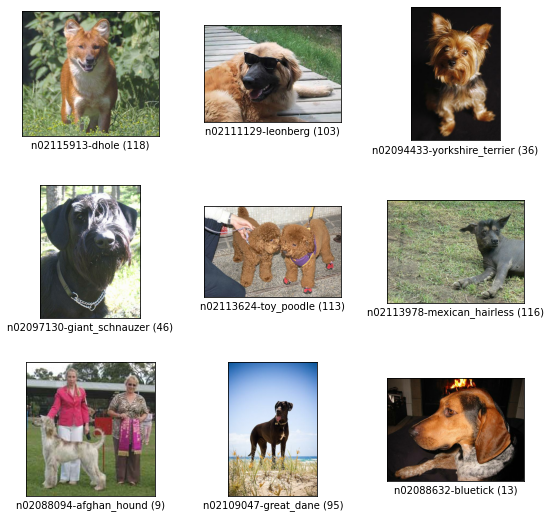

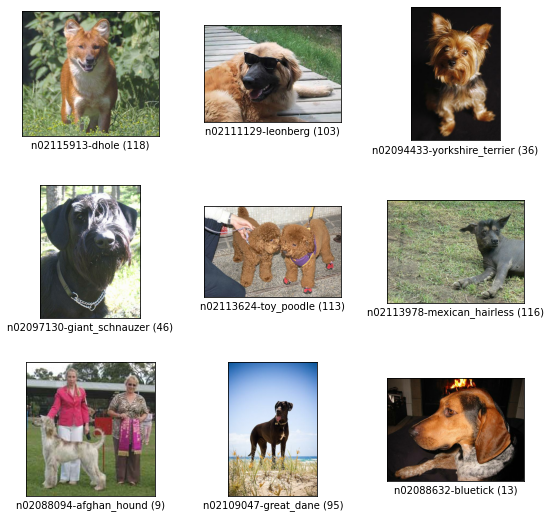

In [4]:
tfds.show_examples(ds_train, ds_info)

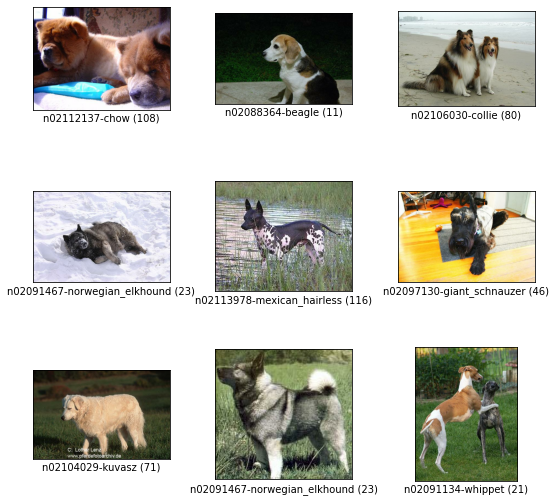

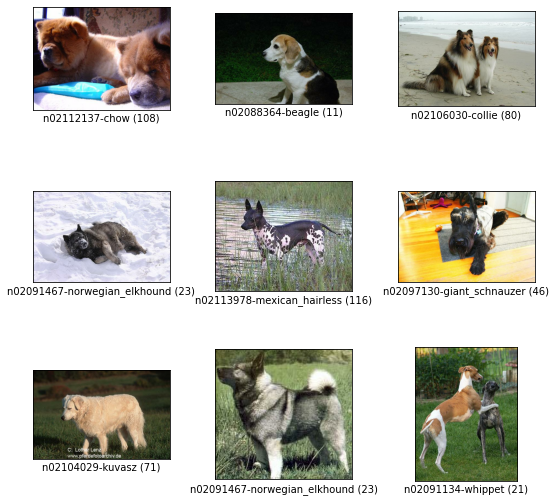

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [7]:
#모델 설계

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes,activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [12]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [13]:
#모델 학습

In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 2.2475 - accuracy: 0.4350 - val_loss: 3.6665 - val_accuracy: 0.1651
Epoch 2/20
750/750 [==============================] - 170s 226ms/step - loss: 0.6268 - accuracy: 0.8390 - val_loss: 1.3652 - val_accuracy: 0.6130
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1678 - accuracy: 0.9748 - val_loss: 1.0419 - val_accuracy: 0.7048
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0569 - accuracy: 0.9962 - val_loss: 1.0023 - val_accuracy: 0.7175
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0300 - accuracy: 0.9983 - val_loss: 0.9744 - val_accuracy: 0.7271
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0188 - accuracy: 0.9995 - val_loss: 0.9848 - val_accuracy: 0.7282
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0140 - accuracy: 0.9996 - val_loss: 1.0094 -

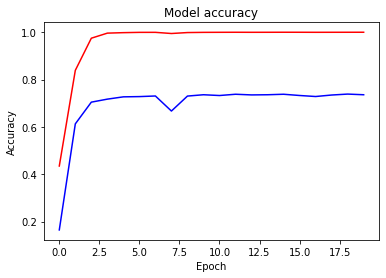

In [15]:
plt.plot(history_cam_model.history['accuracy'], 'r')
plt.plot(history_cam_model.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

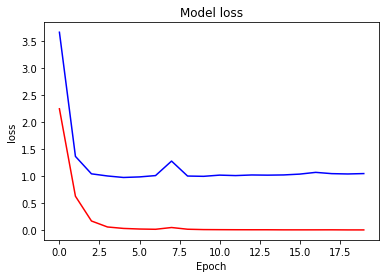

In [16]:
plt.plot(history_cam_model.history['loss'], 'r')
plt.plot(history_cam_model.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [17]:
#활성맵확인

In [65]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

71


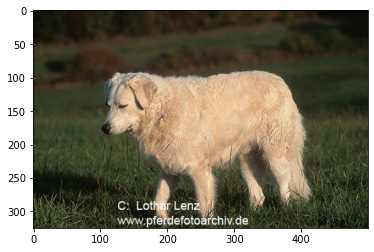

In [66]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [67]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

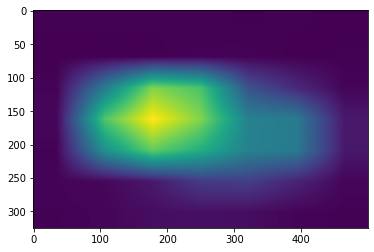

In [68]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [69]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image


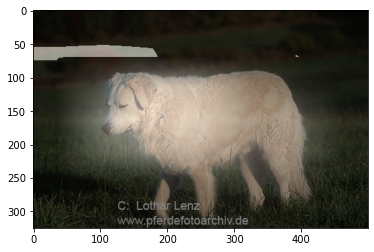

In [70]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [71]:
#

In [72]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [73]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [74]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [75]:
rect = get_bbox(cam_image)
rect

array([[ 39,  73],
       [499,  73],
       [499, 296],
       [ 39, 296]])

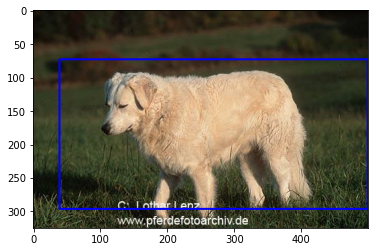

In [76]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [77]:
origin_image.shape

(325, 500, 3)

In [78]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.2246153846153846, 0.078, 0.9107692307692308, 0.998]

In [79]:
item['objects']['bbox']

array([[0.27384615, 0.2       , 0.9969231 , 0.836     ]], dtype=float32)

In [80]:
#iou 계산

In [81]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5904524759215121

In [82]:
#라벨 데이터와 비교

In [83]:
green_bbox = (item['objects']['bbox'])[0]

In [84]:
item['image'].shape

(325, 500, 3)

In [85]:
green_bbox = [(green_bbox[0]*item['image'].shape[0],green_bbox[1]*item['image'].shape[1]),
                (green_bbox[2]*item['image'].shape[0],green_bbox[3]*item['image'].shape[1])]

In [86]:
green_bbox

[(88.99999856948853, 100.00000149011612),
 (324.00000393390656, 418.0000126361847)]

In [87]:
for idx, i in enumerate(green_bbox):
    green_bbox[idx] = list(map(int, i)) 

In [88]:
green_bbox

[[88, 100], [324, 418]]

In [89]:
img = cv2.rectangle(image, green_bbox[0], green_bbox[1], (0,255,0), 3)

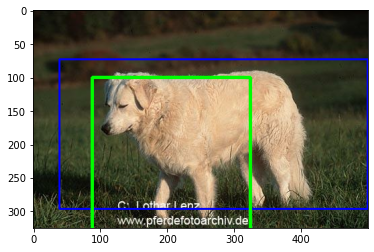

In [90]:
plt.imshow(img)
plt.show()

In [91]:
#활성맵 확인

90


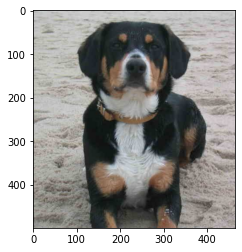

In [152]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [153]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

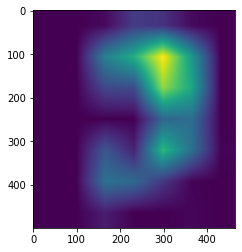

In [154]:
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image5)
plt.show()

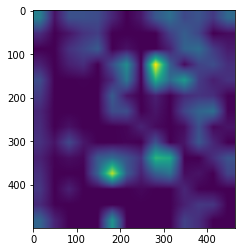

In [155]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.show()

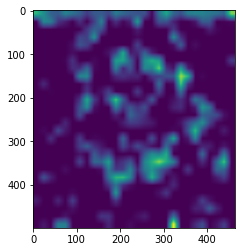

In [156]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

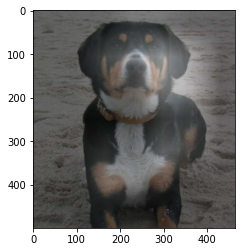

In [157]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([(grad_cam_image5)*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [158]:
rect = get_bbox(grad_cam_image5)
rect

array([[107, 498],
       [107,   0],
       [423,   0],
       [423, 498]])

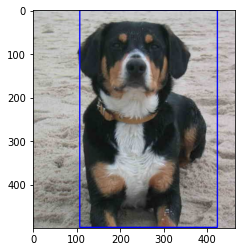

In [159]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [160]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.23060344827586207, 0.996, 0.9116379310344828]

In [161]:
item['objects']['bbox']

array([[0.05      , 0.21767241, 0.996     , 0.86206895]], dtype=float32)

In [162]:
#iou 계산

In [163]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.8650674353589825

In [164]:
#라벨 데이터와 비교

In [165]:
green_bbox = (item['objects']['bbox'])[0]

In [166]:
green_bbox = [(green_bbox[0]*item['image'].shape[0],green_bbox[1]*item['image'].shape[1]),
                (green_bbox[2]*item['image'].shape[0],green_bbox[3]*item['image'].shape[1])]

In [167]:
green_bbox

[(25.00000037252903, 100.99999713897705),
 (497.99999594688416, 399.9999933242798)]

In [168]:
for idx, i in enumerate(green_bbox):
    green_bbox[idx] = list(map(int, i)) 

In [169]:
green_bbox

[[25, 100], [497, 399]]

In [170]:
img = cv2.rectangle(image, green_bbox[0], green_bbox[1], (0,255,0), 3)

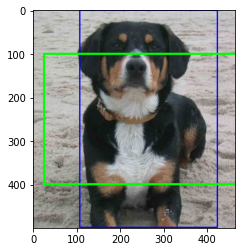

In [171]:
plt.imshow(img)
plt.show()